In [272]:
import pandas as pd
import numpy as np
import os.path
from os import path


pd.set_option('display.max_rows', 500)
if path.exists("/kaggle/input/apache-hadoop-ozone-contributions"):
   os.chdir("/kaggle/input/apache-hadoop-ozone-contributions")


In [350]:
contributions = pd.read_csv("github-contribution.csv.gz")
contributions.date = pd.to_datetime(contributions.date * 1000000, utc = True)

Latest record from the dataset:

In [366]:
contributions.sort_values("date", ascending=False).head(1)
# contributions = contributions[contributions.date > '2020-06-01']

,org,repo,type,identifier,subidentifier,date,author,owner
7843,apache,ozone,PR_COMMENTED,1766,NaN,2021-02-11 04:27:15+00:00,bharatviswa504,bharatviswa504


# Github Contributions per user


In [367]:
c = contributions[["identifier","author","type","own"]].groupby(["author","type","own"]).count() \
   .reset_index().rename(columns={"identifier":"contributions"})
#contributions per user
c[~c.own][["author","contributions"]].groupby("author").sum().sort_values("contributions",ascending=False).head(10)


KeyError: "['own'] not in index"

## Contributors per participations in PRs which are not created by self (helping PRs)

In [368]:
c = contributions[~contributions.own][["identifier","author"]].groupby(["identifier","author"]).count() \
   .reset_index().groupby("author").count()
c.sort_values("identifier",ascending=False).head(20)

AttributeError: 'DataFrame' object has no attribute 'own'

## Contributors per participations in any PRs

In [369]:
c = contributions[["identifier","author"]].groupby(["identifier","author"]).count() \
   .reset_index().groupby("author").count()
c.sort_values("identifier",ascending=False).head(20)

,identifier
author,
adoroszlai,359
elek,291
bharatviswa504,157
xiaoyuyao,140
bshashikant,106
amaliujia,102
avijayanhwx,93
GlenGeng,84
ChenSammi,81


# Bus factor (number of contributors responsible for the 50% of the prs)

## Contributors until the half of the all contributions

In [370]:
prcreated = contributions[contributions.type == "PR_CREATED"]
prcreated = prcreated[["identifier"]].groupby(prcreated.author).count().reset_index()
prcreated = prcreated.sort_values("identifier", ascending=False)
prcreated = prcreated.reset_index(drop=True)
prcreated["cs"] = prcreated["identifier"].cumsum()
prcreated["ratio"]= prcreated.identifier / prcreated.identifier.sum()  * 100
prcreated[prcreated.cs < prcreated.identifier.sum() / 2]

,author,identifier,cs,ratio
0,adoroszlai,129,129,13.976165
1,elek,81,210,8.775731
2,GlenGeng,48,258,5.200433
3,bharatviswa504,46,304,4.983749
4,maobaolong,37,341,4.008667
5,amaliujia,35,376,3.791983
6,runzhiwang,32,408,3.466956
7,captainzmc,29,437,3.141928


## Pony number (bus factor)

In [371]:
pn = (prcreated[prcreated.cs < prcreated.identifier.sum() / 2]).shape[0] + 1
pn

9

## Dev power (All the contributions in the ration of the top contributor)

In [372]:
prcreated["power"] = prcreated["identifier"] / prcreated.reset_index()["identifier"][0] 
prcreated.power.sum()

7.155038759689924

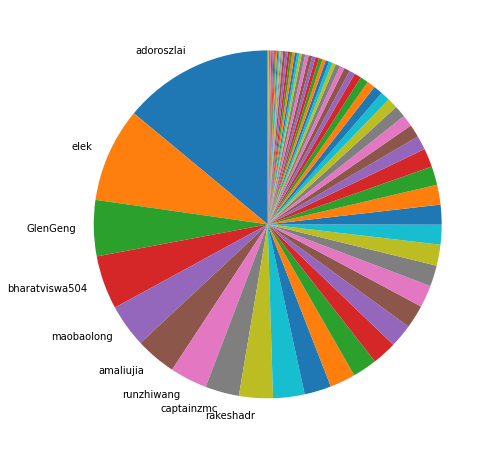

In [373]:
labels = np.asarray(prcreated["author"])
for i in range(pn,len(labels)):
    labels[i] = ""
plt.figure(figsize=(10,8))
plt.pie(prcreated["ratio"], labels=labels, startangle=90)
plt.show()


## People with created PRs > reviewed/commented PRS

In [374]:
created = contributions[contributions.type == "PR_CREATED"][["author","identifier"]].groupby("author").count().rename(columns={"identifier":"created"})
helped = contributions[~contributions.own][["identifier"]].groupby([contributions.author,contributions.identifier]).sum().rename(columns={"identifier":"helped"}) \
  .reset_index().groupby(["author"]).count().drop(columns=["identifier"])
merged = pd.merge(helped,created, left_index=True, right_index=True)

gh = pd.read_csv("ozone_github_memberhsip.csv")
merged.index = merged.index.rename("githubname")
merged = merged.join(gh.set_index("githubname")).reset_index()
merged.role = merged.role.fillna("?")
merged["rc"] = merged.role.map({"pmc":"red","committer":"yellow","?":"blue"})


AttributeError: 'DataFrame' object has no attribute 'own'

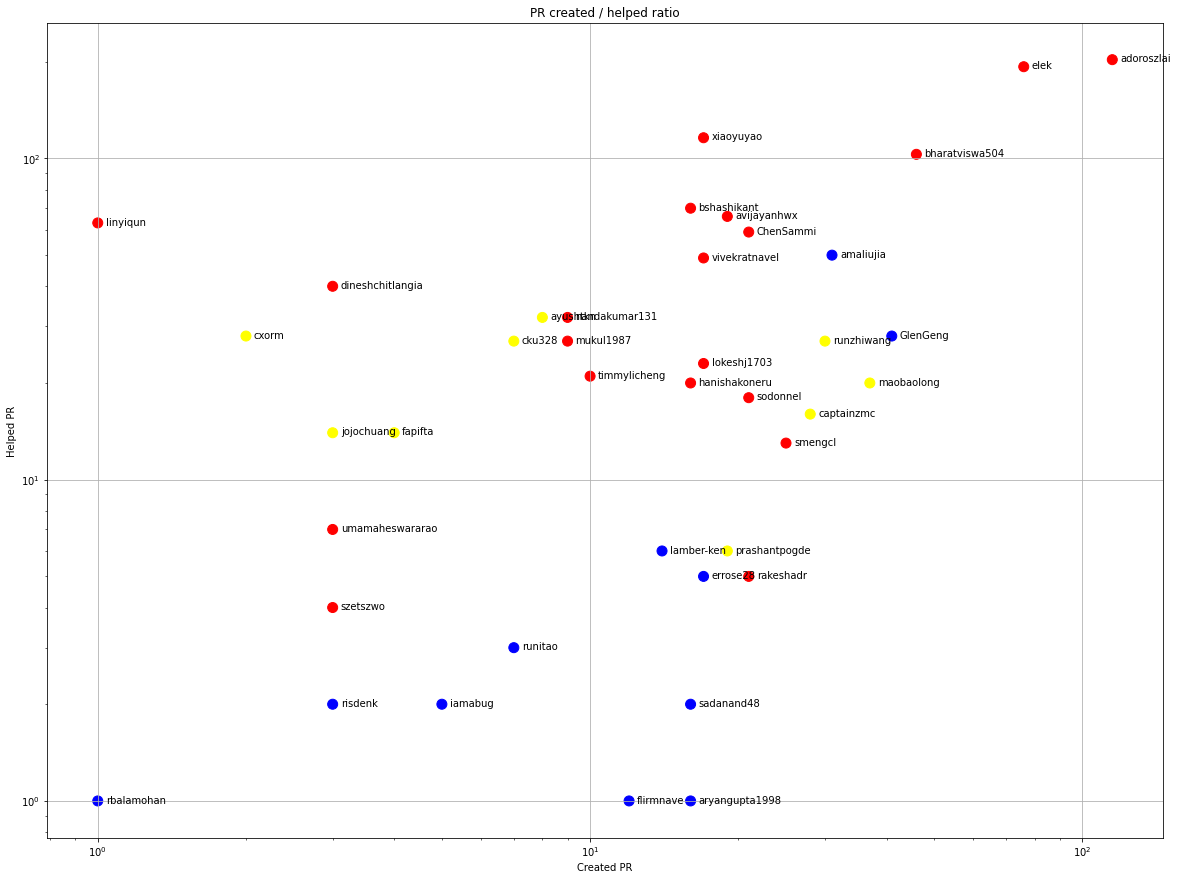

In [375]:
source = merged.reset_index()
import matplotlib.pyplot as plt

plt.figure(figsize=(20,15))

plt.scatter(source.created,source.helped,color=source.rc, s= 100)

plt.xlabel('Created PR')
plt.ylabel('Helped PR')
plt.title('PR created / helped ratio')
plt.grid()

for index, row in source.iterrows():
     plt.annotate(row["githubname"], (row["created"], row["helped"]), xytext=(8,-2), textcoords='offset points')
plt.semilogx()
plt.semilogy()
plt.show()

# Number of individual contributors per month

Number of different Github users who either created PR, commented PR, added review to a PR

Note: only events from apache/hadoop-ozone repository are included. Earlier PRs/comments are not here.

In [377]:
m = contributions[["identifier"]].groupby([contributions.date.dt.to_period("M"),contributions.author]).count() \
  .reset_index()
result = m[["author"]].groupby([m.date]).count().sort_values("date").reset_index()

In [378]:
result.tail(12)

,date,author
0,2020-06,48
1,2020-07,46
2,2020-08,39
3,2020-09,45
4,2020-10,40
5,2020-11,47
6,2020-12,42
7,2021-01,47
8,2021-02,35


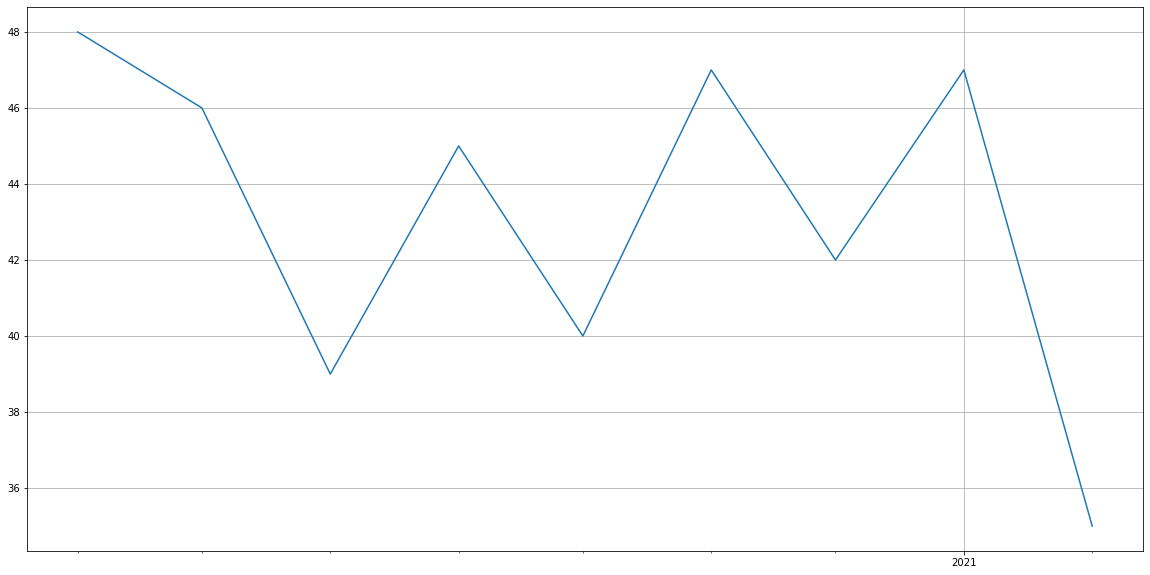

In [379]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


result['d'] = result['date'].apply(pd.Period.to_timestamp)
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot('d', 'author', data=result)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_minor_locator(mdates.MonthLocator())

ax.grid(True)

plt.show()

# Number of PRs closed/created per month

In [380]:
a = contributions[contributions.type.isin(["PR_CREATED","PR_MERGED"])]
a = a[["identifier"]].groupby([a.date.dt.to_period("M"),a.type]).count().reset_index()
a = a.pivot(index="date",columns="type",values="identifier")
a.sort_values("date",ascending=False).head(10)
a.columns = ["created","merged"]
a = a.reset_index()

/usr/lib/python3.9/site-packages/pandas/core/arrays/datetimes.py:1101: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


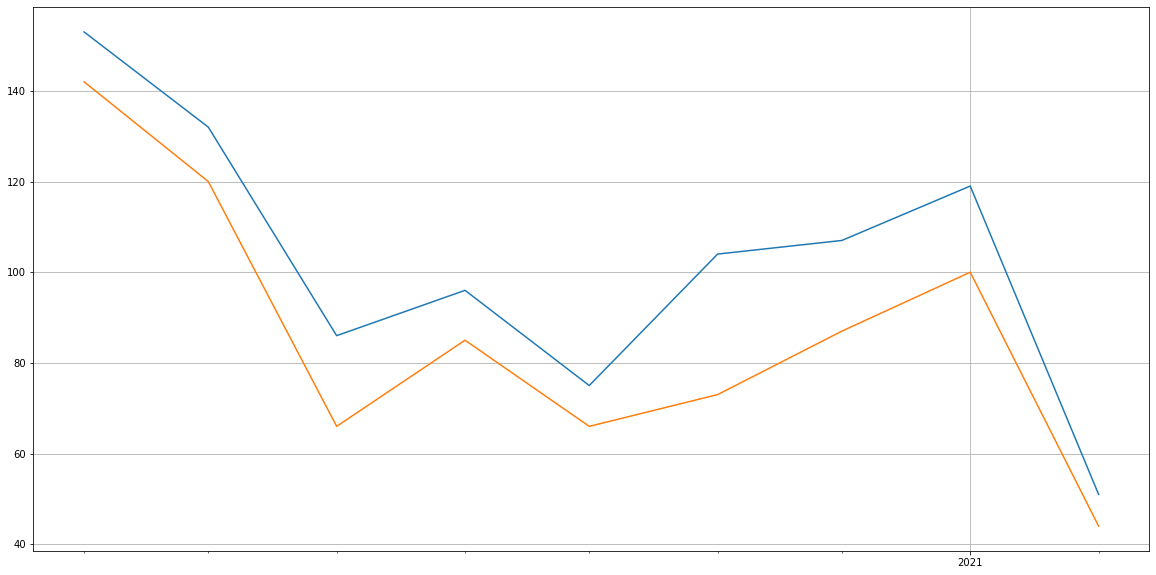

In [381]:
a['d'] = a['date'].apply(pd.Period.to_timestamp)
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot('d', 'created', data=a)
ax.plot('d', 'merged', data=a)

ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_minor_locator(mdates.MonthLocator())

ax.grid(True)

plt.show()

## Monthly comments

In [382]:
contributions[contributions.type == "PR_COMMENTED"][["identifier"]].groupby([contributions.date.dt.to_period("M")]).count()

/usr/lib/python3.9/site-packages/pandas/core/arrays/datetimes.py:1101: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


,identifier
date,
2020-06,562
2020-07,411
2020-08,306
2020-09,330
2020-10,200
2020-11,298
2020-12,315
2021-01,355
2021-02,198
